In [1]:
from collections import namedtuple

import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage
import SimpleITK as sitk

from biopandas.pdb import PandasPdb
from scipy import ndimage
from scipy.spatial.transform import Rotation

In [2]:
Status = namedtuple("Status", ["stop_condition", "num_iterations", "metric_value"])

def parse_pdb(path, record_name):
    """Reads pdb file atoms into arrays of centroids and radii."""
    element_to_radius = {'C': 5, 'O': 5}
    
    df = PandasPdb().read_pdb(path).df[record_name]

    max_radius = max(element_to_radius.values())
    centers = df[['z_coord', 'y_coord', 'x_coord']].values
    centers += 2 + max_radius - centers.min(axis=0)
    
    radii = df['element_symbol'].map(element_to_radius).values
    
    return centers, radii


def register_3d_masks(fixed_mask, moving_mask):
    """Rigid 3d registration based on Euclidean Distance Transform of input masks."""

    # Euclidean Distance Transform finds distance of each signal pixel from
    # its nearest background pixel.  Background pixels remain zero.
    fixed_image = ndimage.distance_transform_edt(fixed_mask)
    moving_image = ndimage.distance_transform_edt(moving_mask)

    # Convert from numpy to sitk format.
    fixed_image = sitk.GetImageFromArray(fixed_image)
    moving_image = sitk.GetImageFromArray(moving_image)
    
    registration = sitk.ImageRegistrationMethod()

    # What is appropriate for EDT, which are not intensities?
    # registration.SetMetricAsMeanSquares()  
    registration.SetMetricAsCorrelation()
    
    # Using a Rigid 3D transformation where the rotation is parameterized
    # by a versor, which is a unit quaternion.  Quaternions are more
    # numerically stable for optimization problems compared to rotation
    # matrices or rotation vectors.
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image, 
        moving_image, 
        sitk.VersorRigid3DTransform(),
    )
    registration.SetInitialTransform(initial_transform)
    
    # The following rescales the angular dimensions so that they are
    # on the same scale as the spatial dimensions.
    registration.SetOptimizerScalesFromPhysicalShift()

    registration.SetOptimizerAsRegularStepGradientDescent(
        learningRate=2.0,
        minStep=1e-8,
        numberOfIterations=1000,
        gradientMagnitudeTolerance=1e-8,
    )

    final_transform = registration.Execute(fixed_image, moving_image)

    stop_condition = registration.GetOptimizerStopConditionDescription()
    num_iterations = registration.GetOptimizerIteration()
    metric_value = registration.GetMetricValue()  
    status = Status(stop_condition, num_iterations, metric_value)
    
    # downcast from generic transform to VersorRigid3DTransform, which
    # allows direct access to translation and rotation parameters.
    return status, final_transform.Downcast()

def resample(mask, transform):
    """Return mask after being transformed."""
    mask = sitk.GetImageFromArray(mask.astype(np.float32))
    mask = sitk.Resample(mask, mask, transform)
    return sitk.GetArrayFromImage(mask)

def print_transform(transform):
    """Print transform in human-understandable terms."""
    translation_xyz = transform.GetTranslation()
    print('translation (z,y,x)', translation_xyz[::-1])

    versor = transform.GetVersor()
    rotation = Rotation.from_quat(versor).as_euler('zyx', degrees=True)
    print('rotation (z,y,x degrees)', rotation)

In [3]:
def create_images(cavity_centers, cavity_radii, atom_centers, atom_radii):
    """Create two images of the same shape encompassing both cavity and atom data."""
    cavity_extent = max_extent(cavity_centers, cavity_radii)
    atom_extent = max_extent(atom_centers, atom_radii)
    shape = np.maximum(cavity_extent, atom_extent)
    
    cavity = spheres(cavity_centers, cavity_radii, shape)
    atoms = spheres(atom_centers, atom_radii, shape)
    return cavity, atoms

def max_extent(centers, radii):
    """Find how large an image is needed to enclose a set of spheres."""
    max_extents = np.asarray(centers) + np.asarray(radii)[:,None]
    # Add 2 because of how skimage.draw.ellipsoid pads
    return np.ceil(max_extents.max(axis=0)).astype(int) + 2

def spheres(centers, radii, shape):
    """Draw spheres at the given centers with the given radii."""
    assert len(centers) == len(radii)
    img = np.zeros(shape, np.bool_)
    for center, radius in zip(centers, radii):
        add_sphere(center, radius, img)
    return img        

def add_sphere(center, radius, img):
    """Draw a single sphere on an image."""
    # NOTE: the center is rounded down to an integer.
    slices = tuple(slice(int(c)-int(radius)-1, int(c)+int(radius)+2) for c in center)
    # NOTE: the radius it NOT rounded in drawing the ellipsoid.
    img[slices] |= skimage.draw.ellipsoid(radius, radius, radius)

Status(stop_condition='RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 150 iterations. Gradient magnitude (9.74852e-09) is less than gradient magnitude tolerance (1e-08).', num_iterations=151, metric_value=-0.7829330577469882)

translation (z,y,x) (1.957008167223229e-05, -3.2535895178033503, 1.306712372471123)
rotation (z,y,x degrees) [-4.49998169e+01 -6.89350702e-06 -2.23440018e-05]

Overlap fraction: 1.0


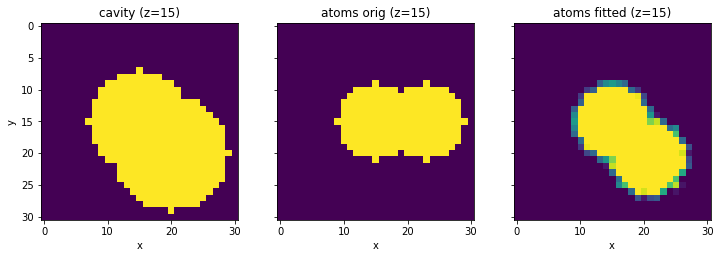

In [4]:
# Create and check on test data.

cavity_centers = [[15, 15, 15], [15, 20, 20]]
cavity_radii = [8, 9]

atom_centers = [[15, 15, 15], [15, 15, 23]]
atom_radii = [6, 6]

cavity, atoms = create_images(
    cavity_centers, 
    cavity_radii, 
    atom_centers, 
    atom_radii,
)

status, transform = register_3d_masks(cavity, atoms)
atoms_xform = resample(atoms, transform)
overlap_frac = atoms_xform[cavity].sum() / atoms_xform.sum()

print(status)
print()
print_transform(transform)
print()
print("Overlap fraction:", overlap_frac)

_, axes = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
axes[0].imshow(cavity[15])
axes[0].set_title("cavity (z=15)")
axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[1].imshow(atoms[15])
axes[1].set_title("atoms orig (z=15)")
axes[1].set_xlabel("x")
axes[2].imshow(atoms_xform[15]);
axes[2].set_title("atoms fitted (z=15)")
axes[2].set_xlabel("x")
plt.show()

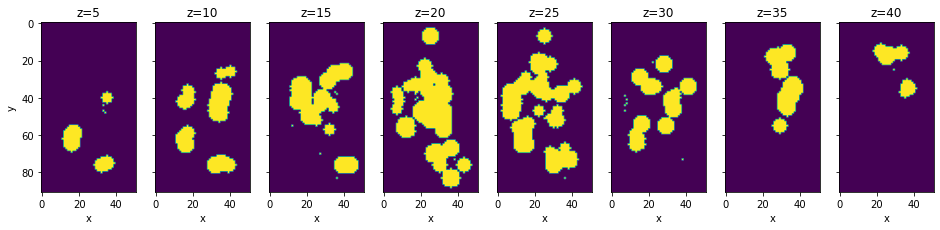

In [5]:
# Plot slices of the retinal molecule
retinal_centers, retinal_radii = parse_pdb("3ug9.pdb", "HETATM")
shape = max_extent(retinal_centers, retinal_radii)
retinal = spheres(retinal_centers, retinal_radii, shape)

_, axes = plt.subplots(ncols=8, figsize=(16,4), sharey=True)
for idx, ax in enumerate(axes):
    if idx == 0:
        ax.set_ylabel("y")
    z = 5 * (idx + 1)
    ax.imshow(retinal[z])
    ax.set_title(f"z={z}")
    ax.set_xlabel("x")
plt.show()